# Import Statements

In [1]:
# Import packages 
import pandas as pd
import numpy as np
import netCDF4
import h5netcdf
import xarray as xr
from os.path import join
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import cartopy
%matplotlib inline
import datetime as dt

import sys
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/samuel.varga/python_packages/WoF_post') #WoF post package
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
from main.io import load_ml_data

from VargaPy.MlUtils import Drop_Unwanted_Variables, get_bl_col, pseudo_all_severe_probs
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from wofs.plotting.wofs_colors import WoFSColors
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader
from wofs_ml_severe.data_pipeline.storm_report_downloader import StormReportDownloader
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/experiments')
from glob import glob

lookup_file: /home/samuel.varga/python_packages/WoF_post/wofs/data/psadilookup.dat


# Load Files

In [2]:
FRAMEWORK='POTVIN'
date='20190520'
init_time='1900'
upscale_size=3
_DX=3*upscale_size
forecast_sizes=np.array([1,3,5])*2
target_sizes=np.array([1,2,4])*2
n_ens=18
ml_config = {'ENS_VARS':['uh_2to5_instant','comp_dz'], 'ENV_VARS':['low_level_lapse_rate'], 'SVR_VARS':['cape_ml']}
dz_levels=np.arange(20,76,5)
cape_levels=np.arange(250,3751,250)
uh_levels=np.arange(40,521,40)

In [3]:
from wofs.post.utils import load_multiple_nc_files
def get_files(path, TIMESCALE):
    """Get the ENS, ENV, and SVR file paths for the 0-3 || 2-6 hr forecasts"""
    # Load summary files between time step 00-36 || 24-72. 
    if TIMESCALE=='0to3':
        ens_files = glob(join(path,'wofs_ENS_[0-3]*')) 
        ens_files.sort()
        ens_files = ens_files[:37] #Drops the last 4 files, so we have 0-36
    elif TIMESCALE=='2to6':
        ens_files = glob(join(path,'wofs_ENS_[2-7]*'))
        ens_files.sort()
        ens_files = ens_files[4:] #Drops the first 4 files, so we have 24-72 instead of 20-72
        print(ens_files[0])
        print(ens_files[-1])
    svr_files = [f.replace('ENS', 'SVR') for f in ens_files]
    env_files = [f.replace('ENS', 'ENV') for f in ens_files]
    
    return ens_files, env_files, svr_files
    
def load_dataset(path, TIMESCALE):
    """Load the 0-3|| 2-6 hr forecasts"""
    ens_files, env_files, svr_files = get_files(path, TIMESCALE)
    
    coord_vars = ["xlat", "xlon", "hgt"]
    
    X_strm, coords, _, _  = load_multiple_nc_files(
                ens_files, concat_dim="time", coord_vars=coord_vars,  load_vars=ml_config['ENS_VARS'])

    X_env, _, _, _  = load_multiple_nc_files(
                env_files, concat_dim="time", coord_vars=coord_vars,  load_vars=ml_config['ENV_VARS'])

    X_svr, _, _, _ = load_multiple_nc_files(
                svr_files, concat_dim="time", coord_vars=coord_vars,  load_vars=ml_config['SVR_VARS'])

    X_env = {**X_env, **X_svr}

    X_env = {v : X_env[v][1] for v in X_env.keys()}
    X_strm = {v : X_strm[v][1] for v in X_strm.keys()}
    
    ll_grid = (coords['xlat'][1].values, coords['xlon'][1].values)
    
    return X_env, X_strm, ens_files[0], ll_grid

In [4]:
from wofs.plotting.util import decompose_file_path
data_path=f'/work/mflora/SummaryFiles/{date}/{init_time}'
X_env, X_strm, ncfile, ll_grid  = load_dataset(data_path, TIMESCALE='2to6') #Load the files for the time scale
target_grid=(ll_grid[0][::upscale_size,::upscale_size], ll_grid[1][::upscale_size,::upscale_size])
comps = decompose_file_path(ncfile)
start_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*5)) #Beginning of forecast window
end_date=(start_date+dt.timedelta(minutes=240)).strftime('%Y%m%d%H%M') #End of forecast window
start_time=start_date.strftime('%Y%m%d%H%M') 
print((start_time, end_date))

/work/mflora/SummaryFiles/20190520/1900/wofs_ENS_24_20190520_1900_2100.nc
/work/mflora/SummaryFiles/20190520/1900/wofs_ENS_72_20190520_1900_0100.nc
('201905202100', '201905210100')


In [5]:
ds = xr.load_dataset(ncfile, decode_times=False)
lats = ds['xlat'][::1, ::1]
lons = ds['xlon'][::1, ::1]
base_grid=[lats,lons]
target_lats = ds['xlat'][::3, ::3]
target_lons = ds['xlon'][::3, ::3]

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g.shp')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection , crs, lat, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax #0000 is 0000 the next day

# 3 km Base 

In [6]:
#Use the first time step for this
print(np.shape(X_strm[ml_config['ENS_VARS'][0]]))
print(np.shape(X_strm[ml_config['ENS_VARS'][0]][0][0]))

(49, 18, 300, 300)
(300, 300)


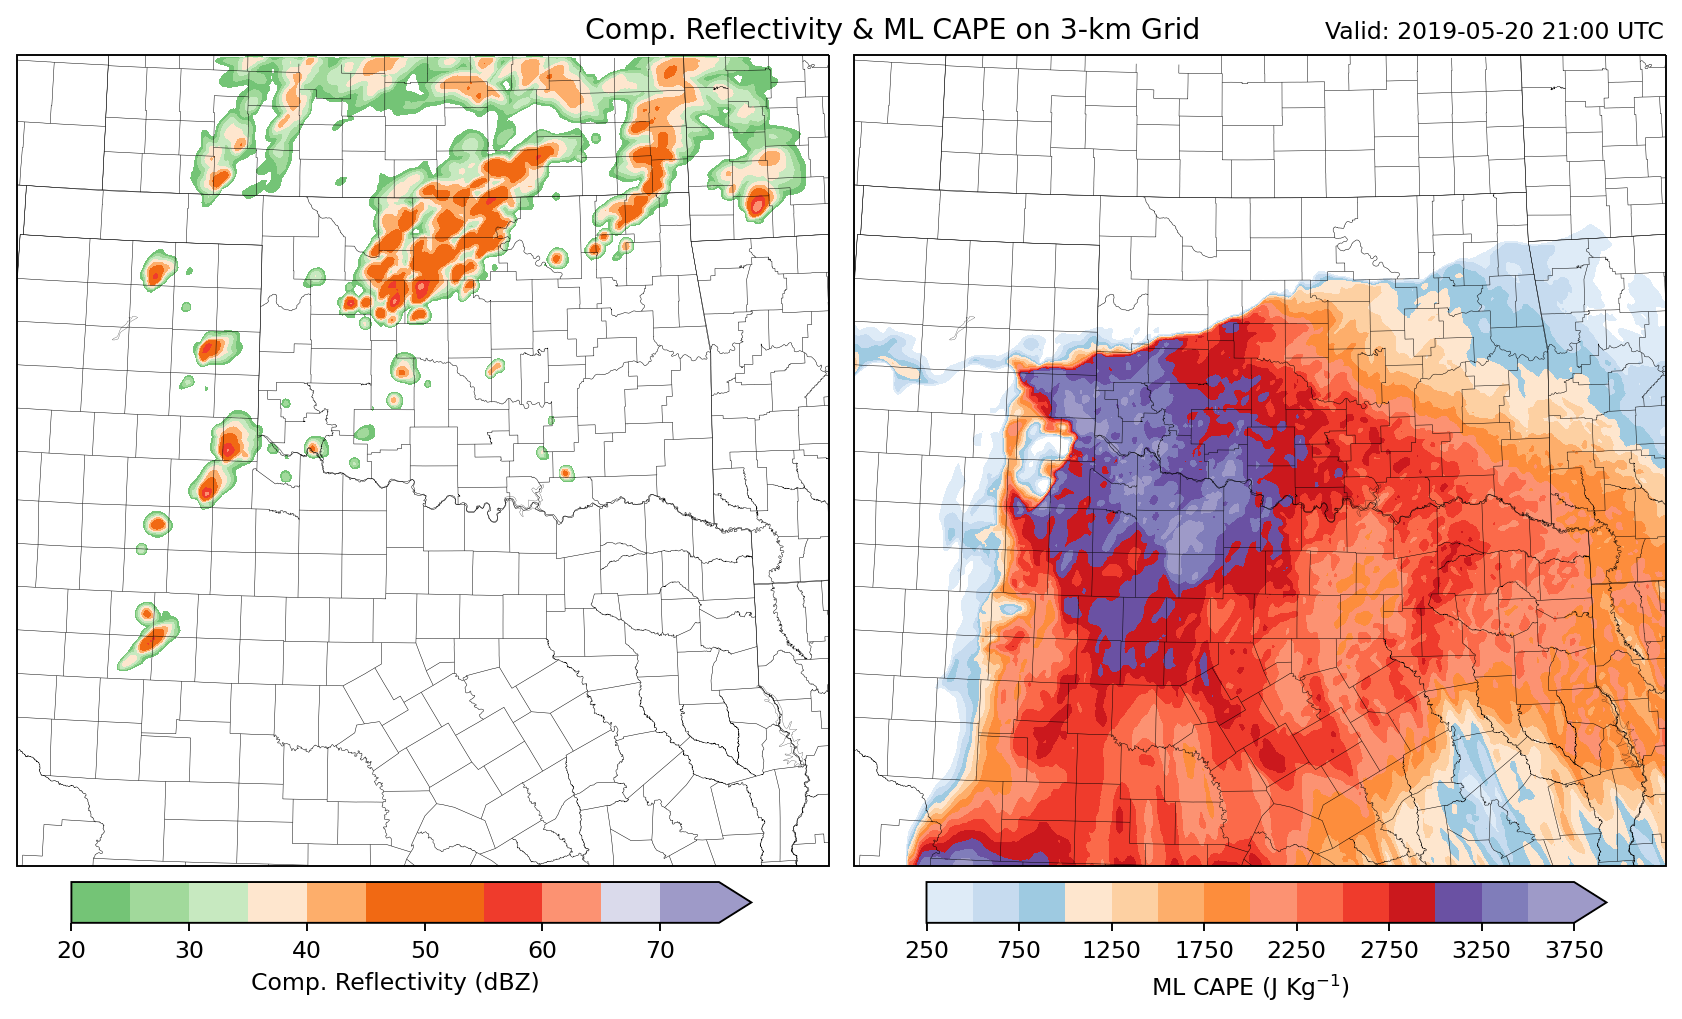

In [7]:
%matplotlib inline

fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, cape_levels]
#cmaps=[WoFSColors.fed_cmap, WoFSColors.cape_cmap]
cmaps=[WoFSColors.dz_cmap, WoFSColors.cape_cmap]
labels=['Comp. Reflectivity (dBZ)', 'ML CAPE (J Kg$^{-1}$)']
title='Comp. Reflectivity & ML CAPE on 3-km Grid'
X_s=[X_strm[ml_config['ENS_VARS'][1]][0][0],X_env[ml_config['SVR_VARS'][0]][0][0]]
conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[base_grid, base_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

        #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
  
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    #ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.7, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        
#title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.58, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# 9 km Upscaled

In [8]:
import pyresample
def resample(variable, original_grid=ll_grid, target_grid=target_grid):
        '''
        Resamples (i.e., re-projects, re-grid) the original grid to the target grid 
        using a nearest neighborhood approach
        
        Parameters
        --------------------
            target_grid: 2-tuple of 2D arrays 
                target latitude and longitude grids for the resampling. 
                
            original_grid : 2-tuple of 2D arrays 
                original latitude and longitude grids prior to the resampling. 
                
            variable : 2D array to be resampled
                The grid to be resampled. 
                
        Return
        -----------------------
            variable_nearest, 2D array of variable resampled to the target grid
        '''
        # Create a pyresample object holding the original grid
        orig_def = pyresample.geometry.SwathDefinition(lons=original_grid[1], lats=original_grid[0])

        # Create another pyresample object for the target grid
        targ_def = pyresample.geometry.SwathDefinition(lons=target_grid[1], lats=target_grid[0])

        variable_nearest = pyresample.kd_tree.resample_nearest(orig_def, variable, \
                    targ_def, radius_of_influence=50000, fill_value=None)

        return variable_nearest

In [9]:
from scipy.ndimage import uniform_filter, maximum_filter, gaussian_filter
import itertools
def upscaler(X, func, size, target_grid=target_grid, n_ens=18, remove_nans=False):
    '''Applies a spatial filter per ensemble member and timestep, then subsamples the grid 
    to reduce the number of grid points'''
    new_X = np.zeros((X.shape[0], X.shape[1], 
                          target_grid[0].shape[0], target_grid[0].shape[1] ))
        
    fill_value = np.nanmean(X)
    for t,n in itertools.product(range(new_X.shape[0]), range(n_ens)):
            X_ = np.nan_to_num(X[t,n,:,:], nan=fill_value)
            new_X[t,n,:,:] = resample(func(X_, size)) #Time, Ens Member, lat/lon
            
    return new_X

In [10]:
# This X has had a 3-grid point gaussian smoother applied to it.
X_env_upscaled = {v  : upscaler(X_env[v], 
                                     func=uniform_filter,
                                     size=upscale_size) for v in X_env.keys()}
        
        # This X has had a 3-grid point maximum filter applied to it. (See above note)
X_strm_upscaled = {v : upscaler(X_strm[v], 
                                     func=maximum_filter,
                                     size=upscale_size) for v in X_strm.keys()}

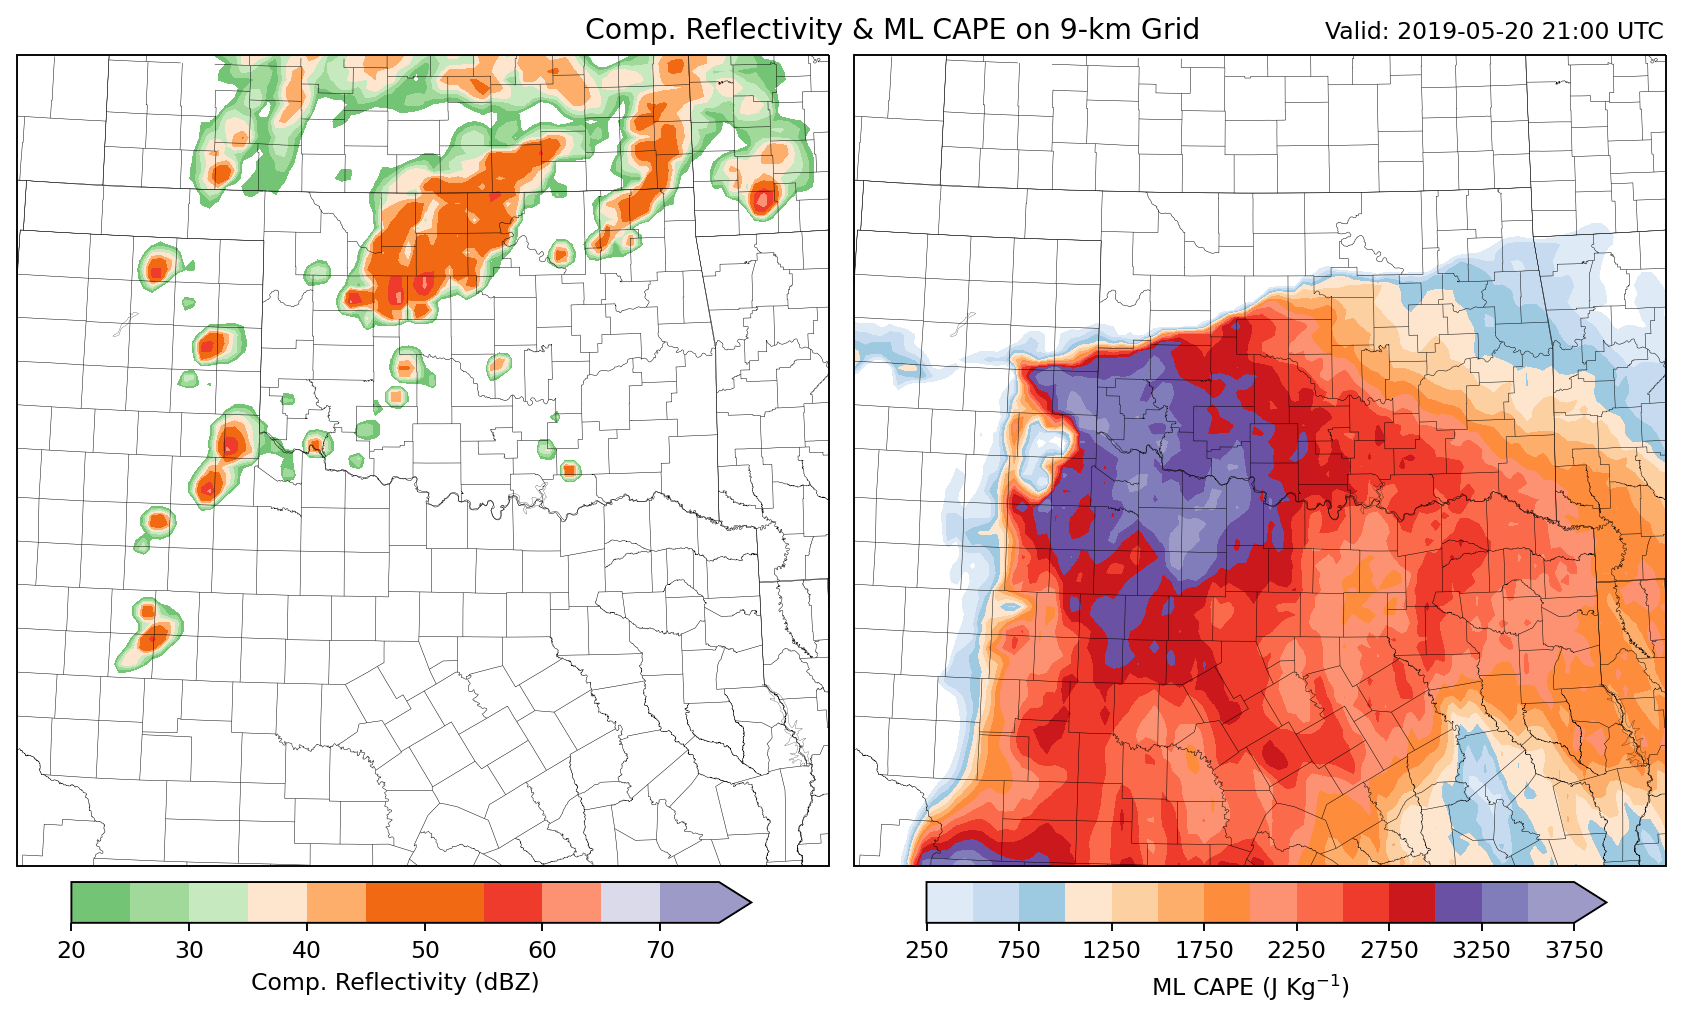

In [11]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, cape_levels]
#cmaps=[WoFSColors.fed_cmap, WoFSColors.cape_cmap]
cmaps=[WoFSColors.dz_cmap, WoFSColors.cape_cmap]
labels=['Comp. Reflectivity (dBZ)', 'ML CAPE (J Kg$^{-1}$)']
title='Comp. Reflectivity & ML CAPE on 9-km Grid'
X_s=[X_strm_upscaled[ml_config['ENS_VARS'][1]][0][0],X_env_upscaled[ml_config['SVR_VARS'][0]][0][0]]
conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

        #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
  
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    #ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.7, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        
#title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.58, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# 9 km Time Composite

In [12]:
def calc_time_composite(X, func, name, keys):
    '''Compute the time-maximum or time-average'''
    X_time_comp={f'{v}__{name}': func(X[v], axis=0) for v in keys}
    return X_time_comp

In [13]:
X_env_time_comp = calc_time_composite(X_env_upscaled, func=np.nanmean, name='time_avg', keys=X_env.keys())
X_strm_time_comp = calc_time_composite(X_strm_upscaled, func=np.nanmax, name='time_max', keys=X_strm.keys())
print(list(X_env_time_comp.keys())[1])

cape_ml__time_avg


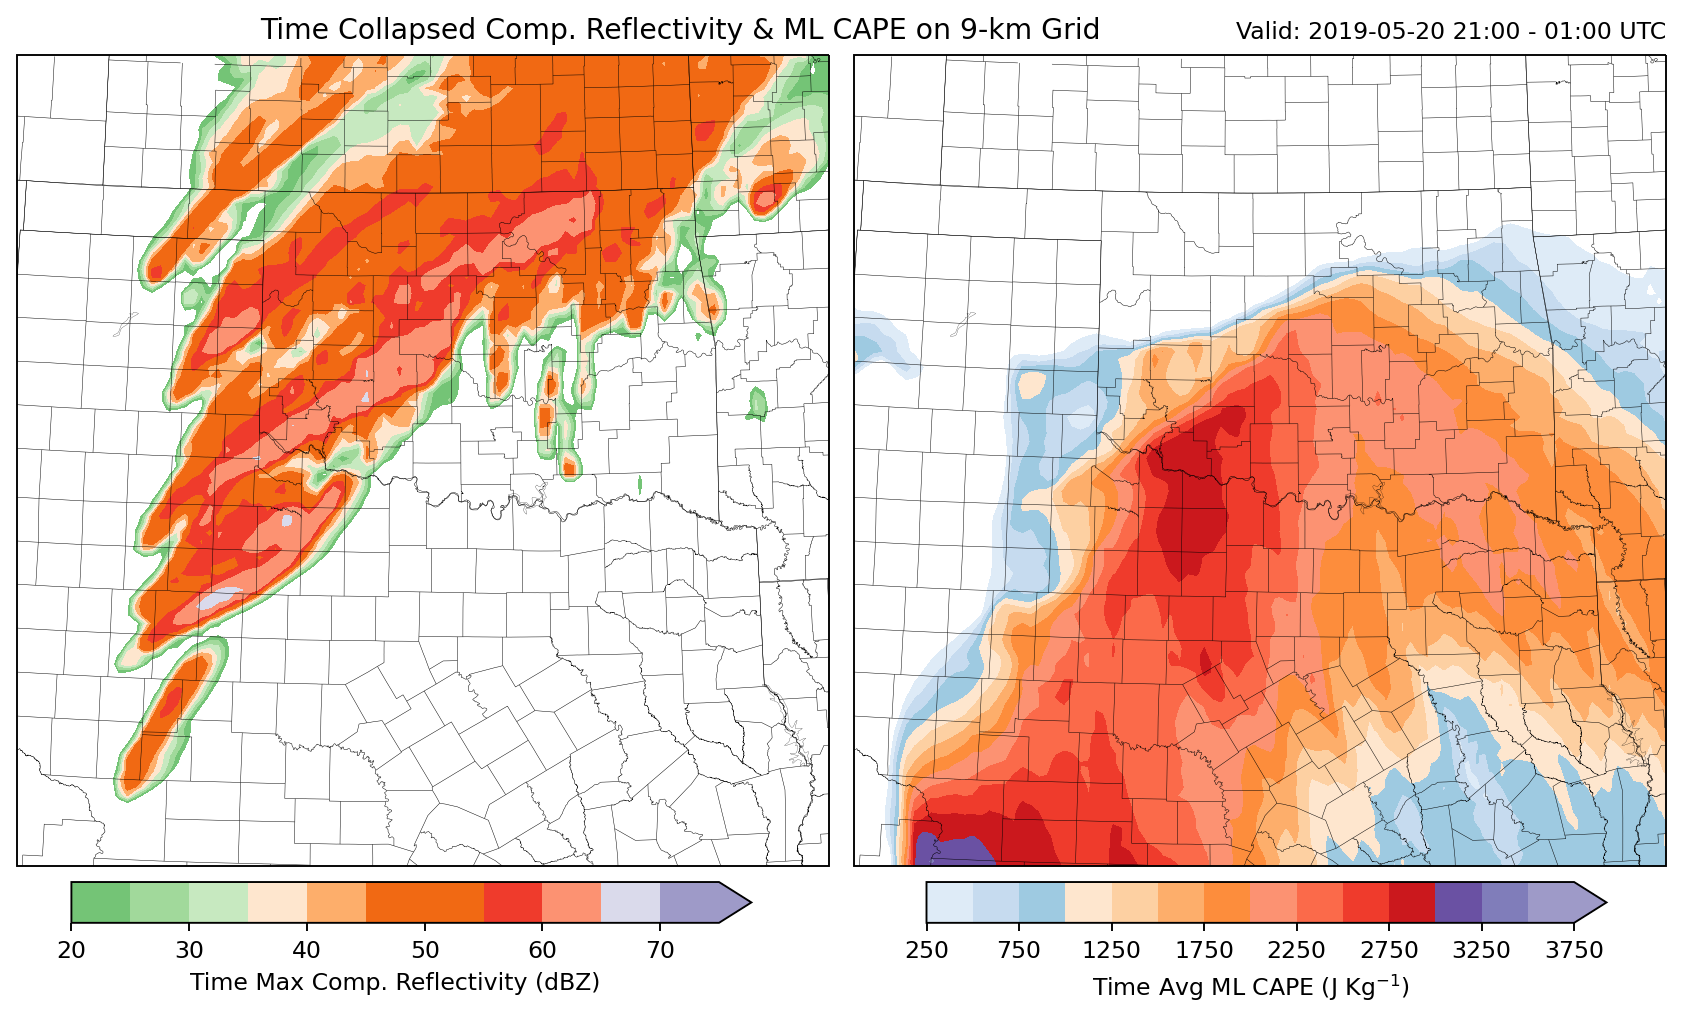

In [14]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=1, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, cape_levels]
#cmaps=[WoFSColors.fed_cmap, WoFSColors.cape_cmap]
cmaps=[WoFSColors.dz_cmap, WoFSColors.cape_cmap]
labels=['Time Max Comp. Reflectivity (dBZ)', 'Time Avg ML CAPE (J Kg$^{-1}$)']
title='Time Collapsed Comp. Reflectivity & ML CAPE on 9-km Grid'
X_s=[]
X_s.append(X_strm_time_comp[list(X_strm_time_comp.keys())[1]][0])
X_s.append(X_env_time_comp[list(X_env_time_comp.keys())[1]][0])
conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

        #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
  
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    #ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

cax = [fig.add_axes([0.047, 0.16, 0.4, 0.03]),fig.add_axes([0.55, 0.16, 0.4, 0.03])]
axes[0].annotate(title, (0.3, 1.02), xycoords='axes fraction', fontsize=12, color='k') #(0.7, 1.02)
for cont, ax, label in zip(conts, cax, labels):
      fig.colorbar(cont, cax=ax,label=label, orientation='horizontal', extend='max')
        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
#time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} UTC'
axes[1].annotate(time_title, (0.47, 1.02), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# 9 km Neighborhoods & Statistics

In [15]:
def neighborhooder(X, func, size, is_2d=False, AdamEnv=False, n_ens=n_ens):
    """Apply neighborhood function to X. For any grid points with NaN values, 
           replace it with a generic, full-domain spatial average value."""
    new_X = X.copy()
    fill_value = np.nanmean(X)
    if is_2d:
            for n in range(n_ens):
                X_ = np.nan_to_num(X[:,:], nan=fill_value)
                new_X[:,:] = func(X_, size)
    else:
            if AdamEnv:
                for t,n in itertools.product(range(new_X.shape[0]), range(n_ens)): #Every time step and ens member
                    X_ = np.nan_to_num(X[t, n, :,:], nan=fill_value)
                    new_X[t,n,:,:] = func(X_, size) 
            else:
                for n in range(n_ens): #Every Ens Member
                    X_ = np.nan_to_num(X[n,:,:], nan=fill_value) 
                    new_X[n,:,:] = func(X_, size)
    return new_X 

In [16]:
def calc_spatial_ensemble_stats(X, environ=True, FRAMEWORK='POTVIN', _SIZES=forecast_sizes, _DX=_DX, n_ens=n_ens):
        """Compute the spatial ensemble mean and standard deviation if environ = True,
        else compute the ensemble 90th. Ensemble statistics are computed in multiple different 
        neighborhood sizes"""
        print(f'{environ} and {FRAMEWORK}')
        keys = X.keys()
        
        X_final = []
        
        for size in _SIZES:
            if environ:
                if FRAMEWORK=='POTVIN':
                    X_nghbrd = {f'{v}__{_DX*size/2:.0f}km' : neighborhooder(X[v], 
                                                                          func=uniform_filter,
                                                                         size=size, 
                                                                               ) for v in keys}

                    X_ens_mean = {f'{v}__ens_mean' : np.nanmean(X_nghbrd[v], axis=0) for v in X_nghbrd.keys()}
                    X_ens_std = {f'{v}__ens_std' : np.nanstd(X_nghbrd[v], axis=0, ddof=1) for v in X_nghbrd.keys()}   
                    X_ens_stats = {**X_ens_mean, **X_ens_std}
                elif FRAMEWORK == 'ADAM':
                    X_nghbrd = {f'{v}__{_DX*1/2:.0f}km' : self.neighborhooder(X[v], 
                                                                          func=uniform_filter,
                                                                         size=1, AdamEnv=True  
                                                                               ) for v in keys} #Returns X[t, n, x, y]

                    X_ens_mean = {f'{v}__ens_mean' : np.nanmean(X_nghbrd[v], axis=1) for v in X_nghbrd.keys()} #Returns X[t,x,y]
                    X_ens_stats = {**X_ens_mean} 
            
            else:
                #Block for storm variables
                if FRAMEWORK=='POTVIN':
                    X_nghbrd = {f'{v}__{_DX*size/2:.0f}km' : neighborhooder(X[v], 
                                                                          func=maximum_filter,
                                                                         size=size,      
                                                                               ) for v in keys}
                  
                    X_ens_mean = {f'{v}__ens_mean' : np.nanmean(X_nghbrd[v], axis=0) for v in X_nghbrd.keys()} #Change 

                   
                    X_ens_16th = {f'{v}__ens_16th' : np.nanpercentile(X_nghbrd[v],
                                                                    16/18*100, axis=0, method='higher') for v in X_nghbrd.keys()} 
                    X_ens_2nd = {f'{v}__ens_2nd' : np.nanpercentile(X_nghbrd[v],
                                                                    2/18*100, axis=0, method='lower') for v in X_nghbrd.keys()}
                    X_strm_iqr={f'{v}__ens_IQR' : np.nanpercentile(X_nghbrd[v],
                                                                    75, axis=0, method='higher')-np.nanpercentile(X_nghbrd[v], 25, axis=0, method='lower') for v in X_nghbrd.keys()}


                    # Compute the baseline stuff. 
                    #X_baseline = self.get_nmep(X_nghbrd, size)

                    X_ens_stats = { **X_ens_mean, **X_ens_2nd, **X_strm_iqr, **X_ens_16th} 
                    
                elif FRAMEWORK=='ADAM':
                    X_nghbrd={f'{v}__{_DX*1/2:.0f}km':self.neighborhooder(X[v],func=maximum_filter, size=1) for v in keys}
                    
                    #Ensemble max at each grid point
                    X_ens_max={f'{v}__ens_max': np.nanmax(X_nghbrd[v], axis=0) for v in X_nghbrd.keys()}
                    
                    #Ensemble 90th %ile at each grid point (No extrapolation)
                    X_ens_90th={f'{v}__ens_16th': np.nanpercentile(X_nghbrd[v], 16/18*100, axis=0, method='higher') for v in X_nghbrd.keys()}
                    
                    #Mean of ensemble at each grid point
                    
                    X_ens_mean={f'{v}__ens_mean':np.nanmean(X_nghbrd[v], axis=0) for v in X_nghbrd.keys()}
                    
                    X_gaussian={f'{v}__smoothed':neighborhooder(X_ens_mean[v], func=gaussian_filter, size=size, is_2d=True) for v in X_ens_mean.keys()}
                    
                    
                    X_smoothed_UH={f'{v}__{_DX*size/2:.0f}km__smoothed' : neighborhooder(X[v], func=gaussian_filter, size=size) for v in keys if 'uh_2to5_instant' in v} 
                    #print(X_smoothed_UH.keys())
                    
                    for v in X_smoothed_UH.keys():
                        X_indiv_UH={f'{v}_{n}' : X_smoothed_UH[v][n,:,:] for n in range(n_ens)}
                    #print(X_nghbrd.keys())
                    #X_baseline=self.get_nmep(X_nghbrd, 1)
                    
                    X_ens_stats={ **X_ens_90th, **X_ens_max, **X_gaussian,**X_indiv_UH}
                                                           
            
            X_final.append(X_ens_stats)
            
                                                          
            
        X_final = dict(ChainMap(*X_final))    
            
        return X_final 

In [25]:
from collections import ChainMap
X_env_stats = calc_spatial_ensemble_stats(X_env_time_comp, environ=True)
X_strm_stats = calc_spatial_ensemble_stats(X_strm_time_comp, environ=False)
print(list(X_env_stats.keys())[1::4]) #1, 5,9
print(list(X_strm_stats.keys())[1::8]) #1,9,17

True and POTVIN
False and POTVIN
['cape_ml__time_avg__45km__ens_mean', 'cape_ml__time_avg__27km__ens_mean', 'cape_ml__time_avg__9km__ens_mean']
['comp_dz__time_max__45km__ens_mean', 'comp_dz__time_max__27km__ens_mean', 'comp_dz__time_max__9km__ens_mean']


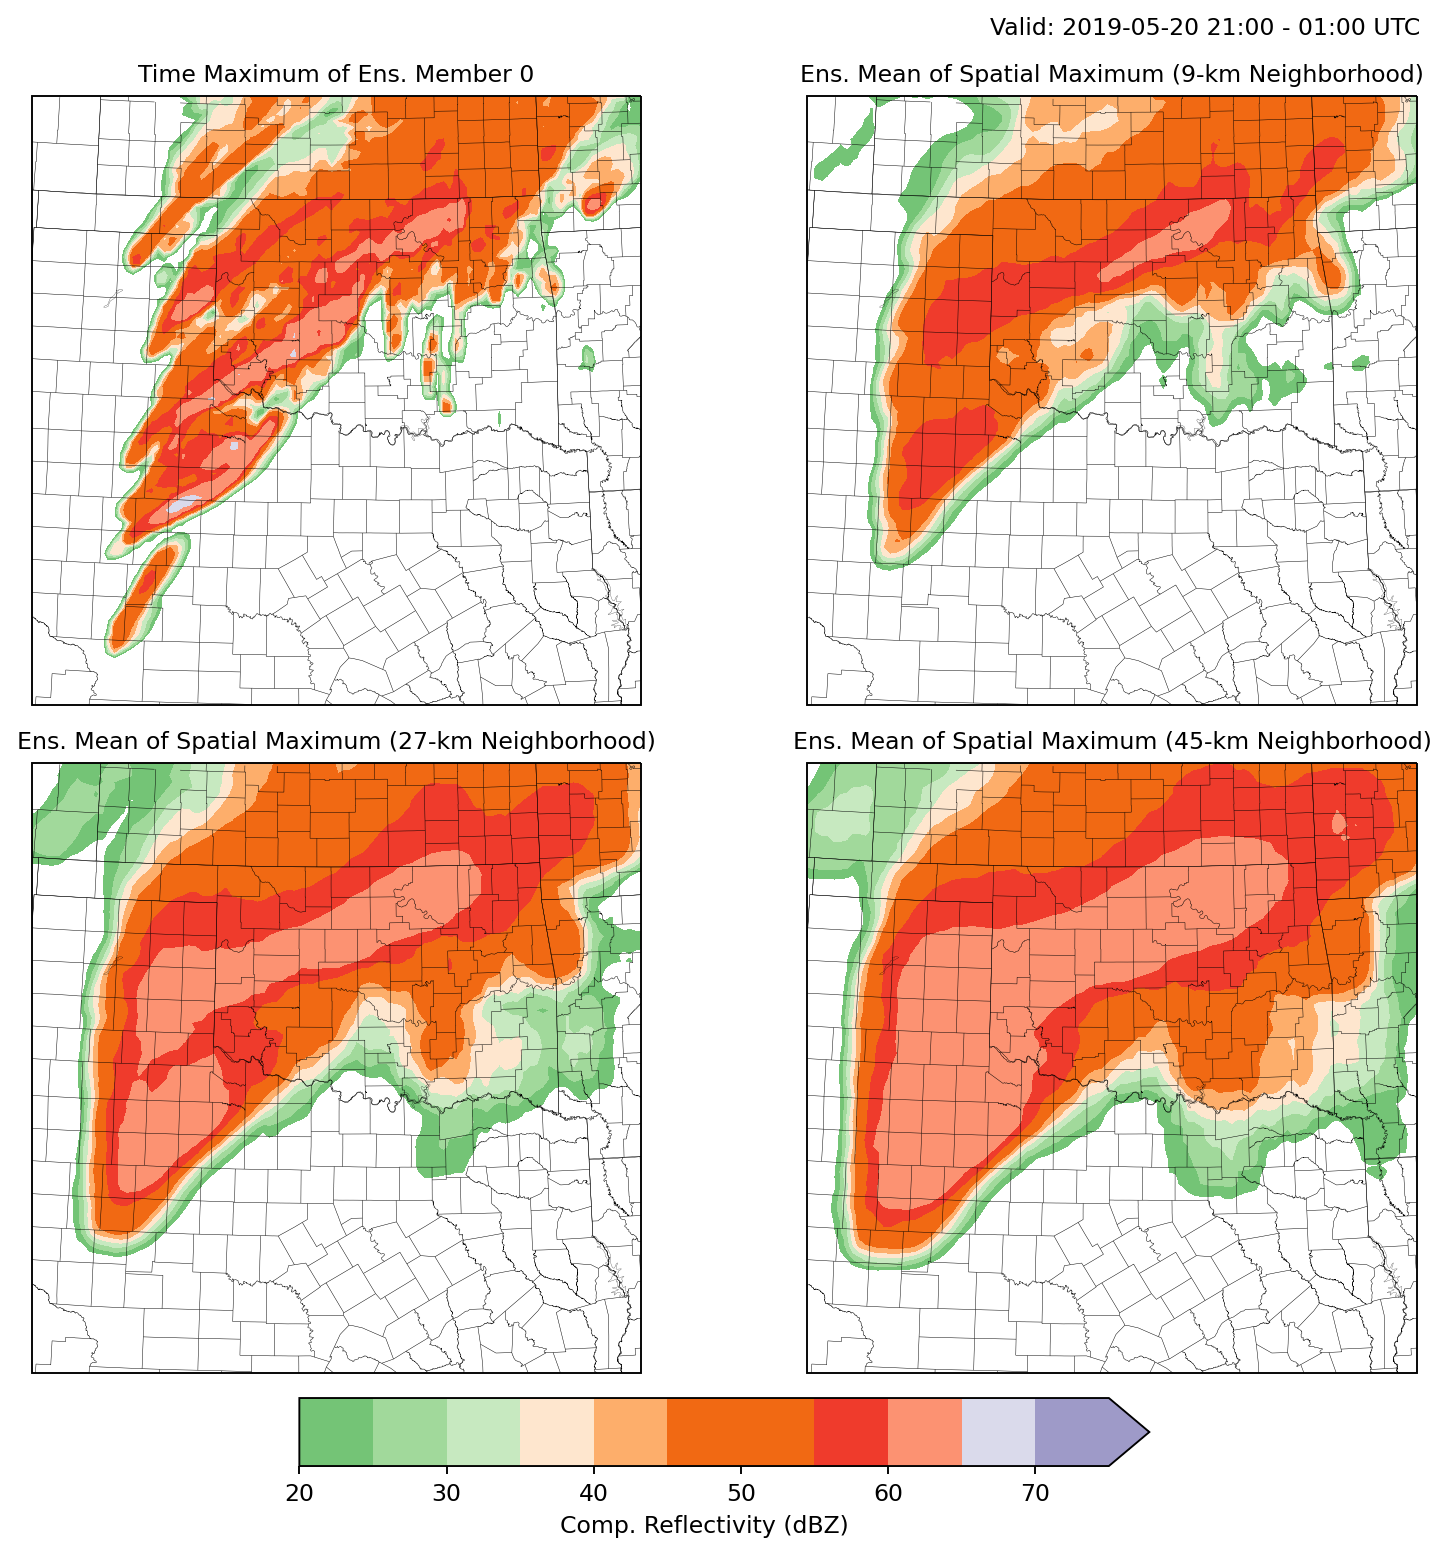

In [41]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [dz_levels, dz_levels,dz_levels,dz_levels]
#cmaps=[WoFSColors.fed_cmap, WoFSColors.cape_cmap]
cmaps=[WoFSColors.dz_cmap, WoFSColors.dz_cmap, WoFSColors.dz_cmap, WoFSColors.dz_cmap]
labels=['Time Maximum of Ens. Member 0', 'Ens. Mean of Spatial Maximum (9-km Neighborhood)','Ens. Mean of Spatial Maximum (27-km Neighborhood)','Ens. Mean of Spatial Maximum (45-km Neighborhood)']
title='Ensemble Statistics of Comp. Reflectivity Neighborhoods on 9-km Grid'

X_s=[X_strm_stats[list(X_strm_stats.keys())[i]] for i in [1,9,17]][::-1]
X_s.insert(0,X_strm_time_comp[list(X_strm_time_comp.keys())[1]][0])

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

        #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

label='Comp. Reflectivity (dBZ)'
cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])
fig.colorbar(cf, cax=cax,label=label, orientation='horizontal', extend='max')

        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
axes[0,1].annotate(time_title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

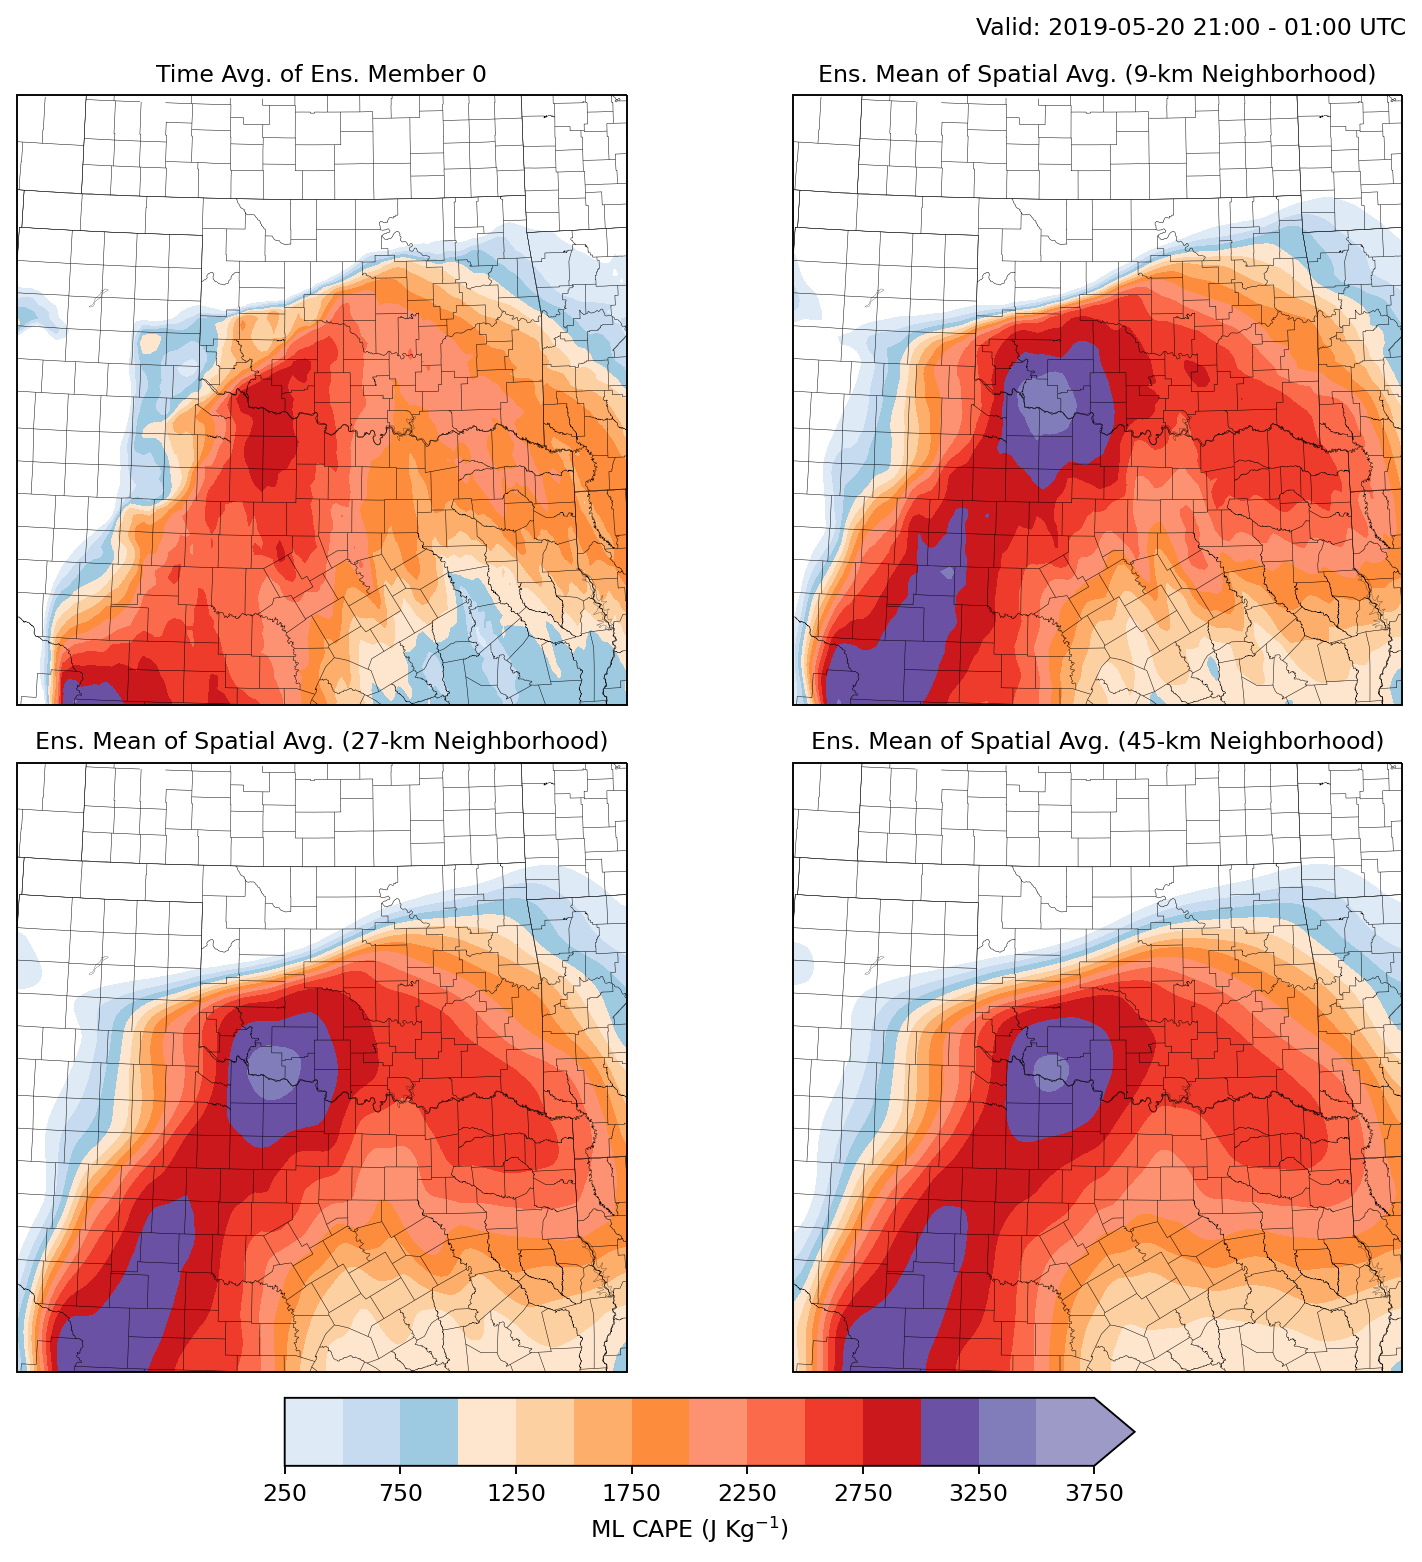

In [42]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)


levels= [cape_levels, cape_levels,cape_levels,cape_levels]
cmaps=[WoFSColors.cape_cmap, WoFSColors.cape_cmap, WoFSColors.cape_cmap, WoFSColors.cape_cmap]
labels=['Time Avg. of Ens. Member 0', 'Ens. Mean of Spatial Avg. (9-km Neighborhood)','Ens. Mean of Spatial Avg. (27-km Neighborhood)','Ens. Mean of Spatial Avg. (45-km Neighborhood)']
title='Ensemble Statistics of ML CAPE Neighborhoods on 9-km Grid'

X_s=[X_env_stats[list(X_env_stats.keys())[i]] for i in [1,5,9]][::-1]
X_s.insert(0,X_env_time_comp[list(X_env_time_comp.keys())[1]][0])

conts=[]
for ax, X, name, grid, cmap, level in zip(axes.flat,X_s,labels,[target_grid, target_grid, target_grid, target_grid], cmaps, levels):
    add_map_stuff(ax, states, shape_feature)

    cf = ax.contourf(grid[1],grid[0], X, transform = crs, cmap=cmap, levels=level, extend='max')
    conts.append(cf)
    
    ax = set_extent(ax, projection , crs, grid[0], grid[1],)
    
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(f'{name}', fontsize=fontsize)

fig.tight_layout()

label='ML CAPE (J Kg$^{-1}$)'
cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])
fig.colorbar(cf, cax=cax,label=label, orientation='horizontal', extend='max')

        
time_title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'        
axes[0,1].annotate(time_title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')
plt.show()

# Target Visualization

# 3 km: Target Mapping

# 3 km: 9km Filter

# 9km: Targets on Upscaled Grid